In [43]:
import numpy as np

from lib.data_preprocessing import remove_correlated_columns
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_offset_data_loader
from lib.model.classification_transformer import TransformerHyperParameters
from lib.torch_device import get_torch_device
from lib.transformer_training import train_transformer_with_cv, train_transformer, test_network

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = get_torch_device()

In [5]:
data_train, labels_train, data_test, labels_test = split(*load_all_data('dataset'), seed=69420)

In [6]:
data_train, data_test = remove_correlated_columns(data_train, data_test)

In [27]:
hyper_parameters = TransformerHyperParameters(
    d_model=512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048,
    dropout=0.1,
    out_size=NUM_CLASSES,
    in_features=data_train.shape[-1],
    lr=1e-5
)

Epoch   0: epoch_loss = 45.628423, num_correct = 16763, num_samples = 86400, acc = 0.194016
Epoch   1: epoch_loss = 5.756580, num_correct = 70869, num_samples = 86400, acc = 0.820243
Epoch   2: epoch_loss = 0.081483, num_correct = 86400, num_samples = 86400, acc = 1.000000
Epoch   3: epoch_loss = 0.031058, num_correct = 86400, num_samples = 86400, acc = 1.000000
Epoch   4: epoch_loss = 0.021285, num_correct = 86400, num_samples = 86400, acc = 1.000000
Epoch   5: epoch_loss = 0.016776, num_correct = 86400, num_samples = 86400, acc = 1.000000
Epoch   6: epoch_loss = 0.013559, num_correct = 86400, num_samples = 86400, acc = 1.000000
Epoch   7: epoch_loss = 0.011006, num_correct = 86400, num_samples = 86400, acc = 1.000000
Evaluated with loss = 6.446884071920068e-08, acc = 1.0


<Figure size 1440x1440 with 0 Axes>

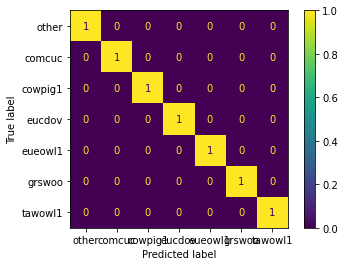

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\domin\AppData\Local\Temp\ipykernel_6984\1396786591.py", line 1, in <cell line: 1>
    train_transformer_with_cv(data_train, labels_train, hyper_parameters, device)
  File "C:\Users\domin\Dropbox\jku\2023SS\344.091 - Machine Learning and Pattern Classification\lib\transformer_training.py", line 38, in train_transformer_with_cv
    train_with_cv(data, labels, create_and_train_func, eval_func)
  File "C:\Users\domin\Dropbox\jku\2023SS\344.091 - Machine Learning and Pattern Classification\lib\training.py", line 36, in train_with_cv
    model = create_and_train_func(data_train_normalized, labels_train)
  File "C:\Users\domin\Dropbox\jku\2023SS\344.091 - Machine Learning and Pattern Classification\lib\transformer_training.py", line 29, in create_and_train_func
    train_network(transformer, da

In [21]:
train_transformer_with_cv(data_train, labels_train, hyper_parameters, device)

In [28]:
transformer = train_transformer(data_train, labels_train, hyper_parameters, device)

Epoch   0: epoch_loss = 94.328698, num_correct =  5201, num_samples = 96000, acc = 0.054177
Epoch   1: epoch_loss = 70.103034, num_correct =  8163, num_samples = 96000, acc = 0.085031
Epoch   2: epoch_loss = 62.443640, num_correct =  9911, num_samples = 96000, acc = 0.103240
Epoch   3: epoch_loss = 53.243493, num_correct = 28442, num_samples = 96000, acc = 0.296271
Epoch   4: epoch_loss = 29.415584, num_correct = 78357, num_samples = 96000, acc = 0.816219
Epoch   5: epoch_loss = 9.516680, num_correct = 89368, num_samples = 96000, acc = 0.930917
Epoch   6: epoch_loss = 2.925699, num_correct = 91293, num_samples = 96000, acc = 0.950969
Epoch   7: epoch_loss = 1.061627, num_correct = 94909, num_samples = 96000, acc = 0.988635


In [59]:
test_loader = create_offset_data_loader(np.random.normal(size=(240, 100, 268)), np.random.randint(0, 7, size=(240, 100)))
print(labels_test.shape)
test_network(transformer, test_loader, device)

(240, 100)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

In [49]:
labels_test.shape

(240, 100)

In [51]:
np.random.randint(0, 7, size=(240, 100))

array([[0, 0, 1, ..., 3, 6, 6],
       [6, 5, 3, ..., 6, 2, 6],
       [6, 5, 2, ..., 2, 0, 6],
       ...,
       [2, 6, 3, ..., 0, 4, 5],
       [4, 4, 5, ..., 3, 2, 0],
       [0, 5, 3, ..., 0, 6, 0]])

In [52]:
np.random.randint(0, 7, size=(240, 100)).shape

(240, 100)